In [1]:
# Results w.r.t. different properties of the molecule

import pickle as pkl
import numpy as np
import matplotlib
#matplotlib.rcParams.update({'font.size': 40})
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import os
import time
from collections import OrderedDict
from summary_utils import read_mols_baseline, read_mols_neuralnet
%matplotlib inline

In [2]:
dataset = 'QM9'
num_conformers = [100]
nn_hyperparams = ["prior_T=1"]

In [3]:
ff_mols = read_mols_baseline('/home/mansimov/projects/dl4chem-geometry/results/ff/{}/_test_/rep_100_iter_200/mols'.format(dataset), num_conformers)

done 0 out of 5000
done 500 out of 5000
done 1000 out of 5000
done 1500 out of 5000
done 2000 out of 5000
done 2500 out of 5000
done 3000 out of 5000
done 3500 out of 5000
done 4000 out of 5000
done 4500 out of 5000
time took 18.145174264907837


In [4]:
nn_mols = OrderedDict()
for nn_i in nn_hyperparams:
    nn_mols[nn_i] = read_mols_neuralnet('/home/mansimov/projects/dl4chem-geometry/results/nn/{}/{}/_test_'.format(nn_i, dataset), num_conformers)

done 0 out of 5000
done 500 out of 5000
done 1000 out of 5000
done 1500 out of 5000
done 2000 out of 5000
done 2500 out of 5000
done 3000 out of 5000
done 3500 out of 5000
done 4000 out of 5000
done 4500 out of 5000
time took 0.9017088413238525


In [5]:
n_rot_bonds = []
n_heavy_atoms = []
for mol_num in ff_mols.keys():
    n_rot_bonds.append(ff_mols[mol_num]['n_rot_bonds'])
    n_heavy_atoms.append(ff_mols[mol_num]['n_heavy_atoms'])

n_rot_bonds = np.array(n_rot_bonds)
n_heavy_atoms = np.array(n_heavy_atoms)

print (np.min(n_rot_bonds), np.median(n_rot_bonds), np.max(n_rot_bonds))
print (np.min(n_heavy_atoms), np.median(n_heavy_atoms), np.max(n_heavy_atoms))


0 1.0 6
3 9.0 9


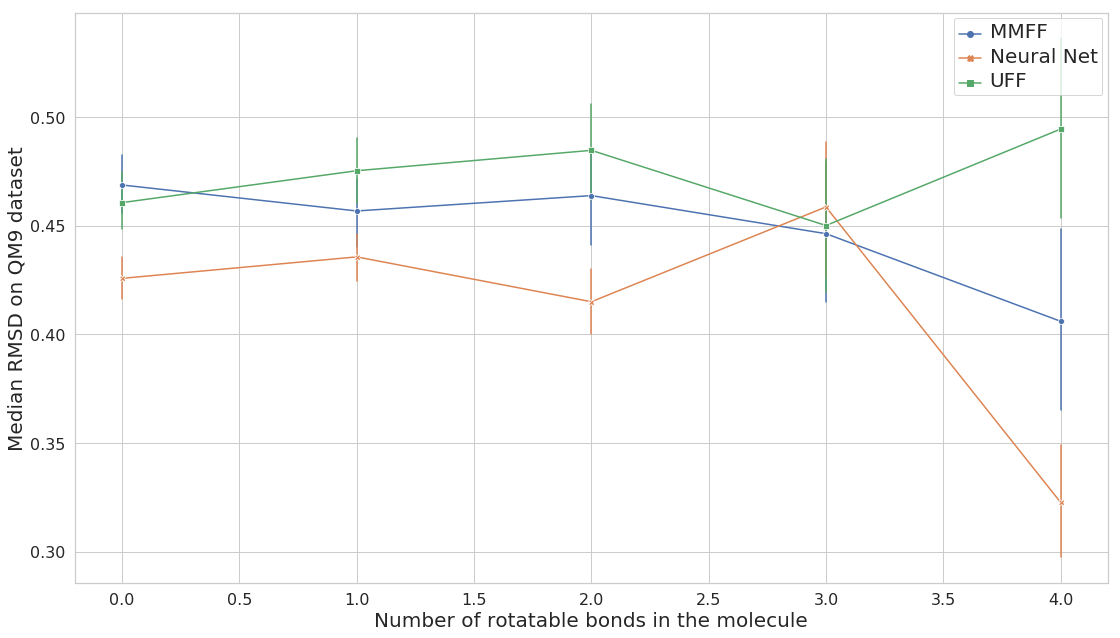

In [17]:
mols_summary = {"rmsd": [], "method": [], "n_rot_bonds": [], "n_heavy_atoms": []}
rot_bonds_stats = {}
heavy_atoms_stats = {}
for mol_num in ff_mols.keys():
    mols_summary["rmsd"].append(np.median(ff_mols[mol_num]["mmff"]))
    mols_summary["rmsd"].append(np.median(ff_mols[mol_num]["uff"]))
    
    mols_summary["method"].extend(["MMFF", "UFF"])
    
    for nn_i in nn_hyperparams:
        nn_mol = nn_mols[nn_i]
        ### NOTE keep in mind that for neural net we only use molecule indicies for which MMFF and UFF baselines succeeded
        mols_summary["rmsd"].append(np.median(nn_mol[mol_num]['rmsd']))
        mols_summary['method'].append("Neural Net")

    n_rot_bonds = ff_mols[mol_num]["n_rot_bonds"]
    n_heavy_atoms = ff_mols[mol_num]["n_heavy_atoms"]
    if dataset == "COD":
        mols_summary["n_rot_bonds"].append(n_rot_bonds if n_rot_bonds < 12 else 12)
    elif dataset == "QM9":
        mols_summary["n_rot_bonds"].append(n_rot_bonds if n_rot_bonds < 4 else 4)
    mols_summary["n_heavy_atoms"].append(n_heavy_atoms)

    if n_rot_bonds not in rot_bonds_stats.keys():
        rot_bonds_stats[n_rot_bonds] = 1
    else:
        rot_bonds_stats[n_rot_bonds] += 1

    if n_heavy_atoms not in heavy_atoms_stats.keys():
        heavy_atoms_stats[n_heavy_atoms] = 1
    else:
        heavy_atoms_stats[n_heavy_atoms] += 1

mols_summary["rmsd"] = pd.Series(mols_summary["rmsd"], dtype="float32")
mols_summary["method"] = pd.Series(mols_summary["method"], dtype="category")
mols_summary["n_rot_bonds"] = pd.Series(mols_summary["n_rot_bonds"], dtype="category")
mols_summary["n_heavy_atoms"] = pd.Series(mols_summary["n_heavy_atoms"], dtype="category")

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = sns.lineplot(x="n_rot_bonds", y="rmsd", hue="method", style="method",\
                  markers=True, dashes=False, ci=68, err_style="bars", \
                  data=mols_summary)

ax.set_xlabel('Number of rotatable bonds in the molecule', fontsize=20)
ax.set_ylabel('Median RMSD on {} dataset'.format(dataset), fontsize=20)
#ax.set_xticklabels(['', '0', '', '1', '2', '', '3', '', '4'])
#ax.set_ylabel('Median RMSD on {} dataset'.format(dataset), fontsize=20)
plt.legend(loc='upper right')
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
ax.tick_params(labelsize=16)

In [7]:
heavy_atoms_stats


{3: 1, 4: 4, 5: 9, 6: 18, 7: 113, 8: 655, 9: 4007}

In [8]:
rot_bonds_stats

{0: 2069, 1: 1463, 2: 759, 3: 331, 4: 149, 5: 35, 6: 1}